In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the vectors from a pickle file
with open('../data/vectors.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
# Load the labels from a pickle file
with open('../data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [4]:
# Standardize the features by scaling
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [5]:
# Split the data into training, validation, and test sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(data, labels, train_size=0.7, random_state=42, shuffle=True, stratify=labels)
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42, shuffle=True, stratify=test_val_labels)

In [6]:
# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data)
val_data_tensor = torch.from_numpy(val_data)
test_data_tensor = torch.from_numpy(test_data)
train_labels_tensor = torch.from_numpy(train_labels)
val_labels_tensor = torch.from_numpy(val_labels)
test_labels_tensor = torch.from_numpy(test_labels)

In [7]:
def create_dataloader(data_tensor, labels_tensor, batch_size, shuffle=False):
    dataset = TensorDataset(data_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Create PyTorch DataLoader objects for training, validation, and testing
train_loader = create_dataloader(train_data_tensor, train_labels_tensor, batch_size=64, shuffle=True)
val_loader = create_dataloader(val_data_tensor, val_labels_tensor, batch_size=64)
test_loader = create_dataloader(test_data_tensor, test_labels_tensor, batch_size=64)

In [8]:
# Define a feedforward neural network model
class DenseNet(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        # Define fully connected layers
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 3)
        # Define activation function
        self.act = nn.ReLU()
        # Define dropout layer
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Forward pass through the network
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)
        out = self.act(out)
        out = self.fc4(out)
        out = self.act(out)
        out = self.fc5(out)

        return out

In [9]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader):
    """
    Function for training the neural network model.

    Args:
        n_epochs (int): Number of epochs for training.
        model (torch.nn.Module): Neural network model.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion: Loss function.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.

    Returns:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
    """
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)

        loss_val = 0.0
        with torch.no_grad():
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_outputs = model(val_data)
                loss_val += criterion(val_outputs, val_labels).item()
            avg_loss_val = loss_val / len(val_loader)
            val_losses.append(avg_loss_val)

        print('{} Epoch {}, Training loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_train))
        print('{} Epoch {}, Validation loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_val))

    return train_losses, val_losses

In [11]:
def plot_losses(train_losses, val_losses):
    """Plot training and validation losses."""
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [12]:
def evaluate_model(model, data_loader):
    """Evaluate the model on the given data loader."""
    loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [13]:
n_epochs = 10
learning_rate = 0.0001

# Instantiate the DenseNet model with dropout
model = DenseNet(dropout=0.5)
# Move the model to the appropriate device (CPU or GPU)
model = model.to(device)
# Define the loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam) and specify the learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_losses, val_losses = training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader)

2024-05-07 21:56:35.986680 Epoch 1, Training loss: 0.6658
2024-05-07 21:56:35.986797 Epoch 1, Validation loss: 0.5748
2024-05-07 21:56:37.566083 Epoch 2, Training loss: 0.5542
2024-05-07 21:56:37.566206 Epoch 2, Validation loss: 0.5616
2024-05-07 21:56:39.253712 Epoch 3, Training loss: 0.5375
2024-05-07 21:56:39.253841 Epoch 3, Validation loss: 0.5525
2024-05-07 21:56:40.845025 Epoch 4, Training loss: 0.5240
2024-05-07 21:56:40.845134 Epoch 4, Validation loss: 0.5425
2024-05-07 21:56:42.467202 Epoch 5, Training loss: 0.5101
2024-05-07 21:56:42.467299 Epoch 5, Validation loss: 0.5390
2024-05-07 21:56:44.035379 Epoch 6, Training loss: 0.4984
2024-05-07 21:56:44.035486 Epoch 6, Validation loss: 0.5334
2024-05-07 21:56:45.604164 Epoch 7, Training loss: 0.4880
2024-05-07 21:56:45.604271 Epoch 7, Validation loss: 0.5304
2024-05-07 21:56:47.107265 Epoch 8, Training loss: 0.4786
2024-05-07 21:56:47.107371 Epoch 8, Validation loss: 0.5315
2024-05-07 21:56:48.726602 Epoch 9, Training loss: 0.469

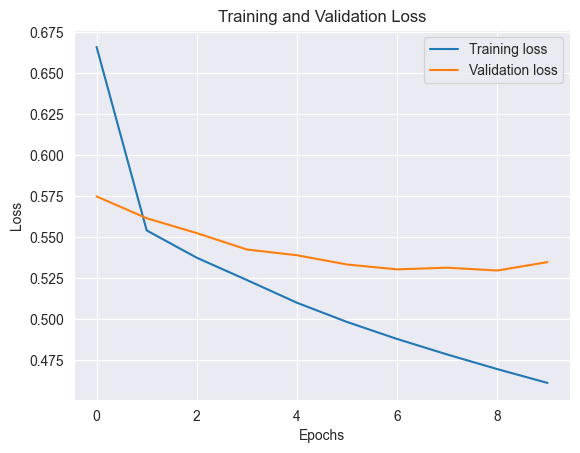

In [15]:
plot_losses(train_losses, val_losses)

In [16]:
evaluate_model(model, val_loader)

(0.5348561610261054, 78.85016862052353)

In [17]:
# Set the model to evaluation mode
model.eval()

# Initialize an empty list to store predictions
predictions = []

# Disable gradient computation since we are in evaluation mode
with torch.no_grad():
    # Iterate over the test data loader
    for data, labels in test_loader:
        # Move the data and labels to the appropriate device
        data, labels = data.to(device), labels.to(device)
        # Forward pass through the model
        outputs = model(data)
        # Append the predictions to the list
        predictions.extend(outputs.tolist())

# Convert the predictions list to a PyTorch tensor
probs = torch.tensor(predictions)
# Determine the predicted classes by taking the argmax along the appropriate dimension
predicted_classes = torch.argmax(probs, dim=1)

In [18]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      8464
           1       0.80      0.81      0.81      5730
           2       0.66      0.73      0.69      4486

    accuracy                           0.79     18680
   macro avg       0.77      0.78      0.77     18680
weighted avg       0.79      0.79      0.79     18680



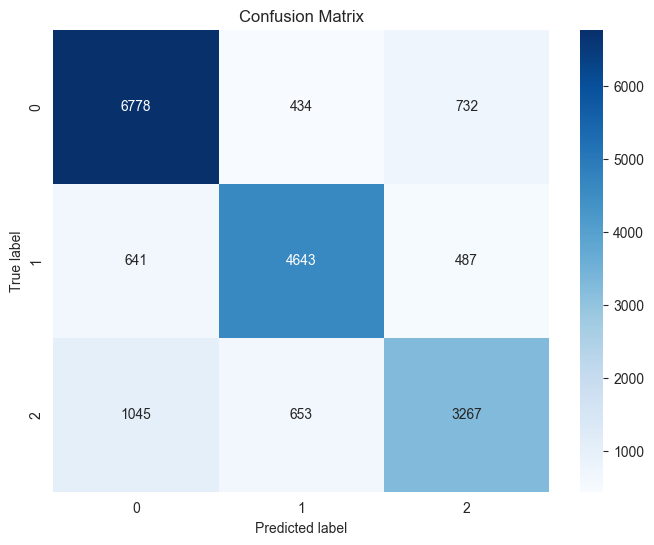

In [19]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Create a heatmap visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression

In [20]:
# Initialize and train a logistic regression classifier
logreg = LogisticRegression()
logreg.fit(train_data, train_labels)

LogisticRegression()

In [21]:
# Make predictions using the trained logistic regression classifier
logreg_predictions = logreg.predict(test_data)

In [22]:
print(classification_report(test_labels, logreg_predictions))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7944
           1       0.77      0.78      0.78      5771
           2       0.71      0.63      0.67      4965

    accuracy                           0.76     18680
   macro avg       0.75      0.75      0.75     18680
weighted avg       0.76      0.76      0.76     18680



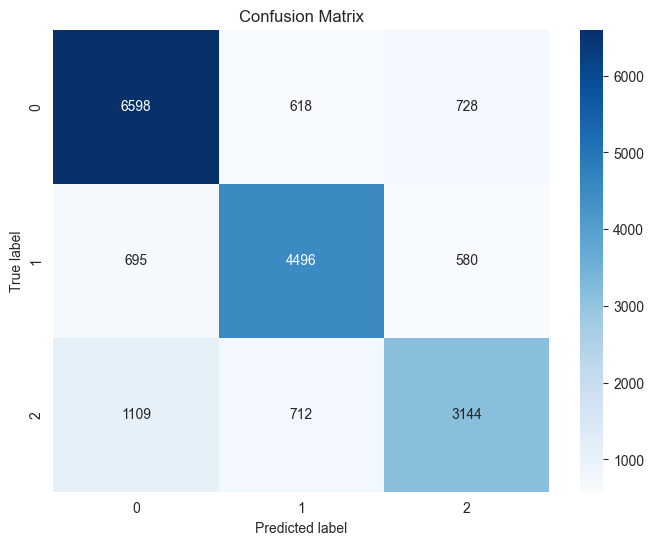

In [23]:
# Generate and display the confusion matrix for logistic regression predictions
conf_matrix = confusion_matrix(test_labels, logreg_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()